# <div align='center' id="top"> Walkthrough Facial Generation using Pretrained VAE task  </div>

In [1]:
import torch
import numpy as np
from torchvision.utils import make_grid
from torchvision import transforms
from PIL import Image, ImageEnhance, ImageFilter
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN

### A. Load the pretrained VAE 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = torch.load("pretrained_weights/vae_model_20.pth", map_location=device)
model.eval()

FileNotFoundError: [Errno 2] No such file or directory: 'vae_model_20.pth'

### B. Detect the faces using `MTCNN` followed by image enhancement `sharpening & contrast`

In [ ]:
def detect_face_mtcnn(image_path, output_size=150):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    mtcnn = MTCNN(image_size=output_size, margin=20, post_process=True, device=device)

    img = Image.open(image_path).convert('RGB')
    face = mtcnn(img) 
    

    if face is None:
        raise ValueError("No face detected.")

    # De-normalize to [0, 1]
    face = (face + 1) / 2
    face_img = transforms.ToPILImage()(face).convert("RGB")
    
    return face_img


def enhance_image(tensor_img):
    img = transforms.ToPILImage()(tensor_img.cpu().clamp(0, 1))
    img = img.filter(ImageFilter.SMOOTH_MORE)
    img = ImageEnhance.Contrast(img).enhance(1.3)
    img = ImageEnhance.Sharpness(img).enhance(2.0)
    img = ImageEnhance.Color(img).enhance(1.2)
    return transforms.ToTensor()(img)



### C. Generate Latent vectors through bunch of variation methods 

1.  Noise interpolation between the input image's vector and the random vector of VAE 

        Parameter (alpha -> linear mix of input and random noise) [0,1] where 1 reflects full noise
    
2.  Latent walk along the latent space

        Parameter (walk scale -> How far you walk away from input face latent vector to random) ]-inf,inf[ 
    
    
3.  Noise Ramp (Non-linear interpolation)

        Parameter (ramp power -> control the non-linear interpolation) 0 refelcts full noise and 1 linear where (ramp_power>1) represent fast transition

In [ ]:
def generate_latents(model, img_tensor, method, num_samples, alpha, walk_scale, ramp_power):
    with torch.no_grad():
        mu, log_var = model.encode(img_tensor)
        z_list = []

        for i in range(num_samples):
            t = i / (num_samples - 1)
            step = (i - num_samples // 2) / (num_samples // 2)

            if (method == 'noise_interp' and alpha == 0) or \
               (method == 'latent_walk' and walk_scale == 0) or \
               (method == 'noise_ramp' and ramp_power == 0):
                z = mu

            elif method == 'noise_interp':
                z_rand = torch.randn_like(mu)
                z = (1 - alpha) * mu + alpha * z_rand

            elif method == 'latent_walk':
                z = mu + step * walk_scale

            elif method == 'noise_ramp':
                ramp = t ** ramp_power
                z_rand = torch.randn_like(mu)
                z = (1 - ramp) * mu + ramp * z_rand

            else:
                z = mu

            z_list.append(z)

        return torch.cat(z_list, dim=0)



### D. Show Different Variations  

`Input` Facial image -> Extract Face -> choose a variation method
`Output` 10 diverse facial images (tuned on your choice of right parameters)

In [ ]:
def show_variations(
    model,
    image_path,
    method='noise_interp',
    num_samples=10,
    alpha=0.5,
    walk_scale=0.6,
    ramp_power=2.0
):
    device = next(model.parameters()).device

    # === Face Detection & Preprocessing ===
    face_img = detect_face_mtcnn(image_path, output_size=150)
    transform = transforms.ToTensor()
    img_tensor = transform(face_img).unsqueeze(0).to(device)

    # === Generate Latent Variations ===
    z_stack = generate_latents(model, img_tensor, method, num_samples, alpha, walk_scale, ramp_power)

    # === Decode and Enhance ===
    with torch.no_grad():
        outputs = model.decode(z_stack).view(-1, 3, 150, 150)
        outputs = torch.stack([enhance_image(img) for img in outputs])

    # === Visualization ===
    grid = make_grid(outputs, nrow=5)
    plt.figure(figsize=(14, 6))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.title(f"Method: {method} | α={alpha} | scale={walk_scale} | ramp^={ramp_power}")
    plt.show()

In [ ]:
def show_advanced_variations_from_image(
    model,
    image_path,
    method='noise_interp',
    num_samples=10,
    alpha=0.5,
    walk_scale=0.6,
    ramp_power=2.0
):
    device = next(model.parameters()).device

    # === Face Detection ===
    face_img = detect_face_mtcnn(image_path, output_size=150)
    

    # === Transform to Tensor ===
    transform = transforms.ToTensor()
    img_tensor = transform(face_img).unsqueeze(0).to(device)

    with torch.no_grad():
        mu, log_var = model.encode(img_tensor)
        z_list = []

        for i in range(num_samples):
            t = i / (num_samples - 1)
            step = (i - num_samples // 2) / (num_samples // 2)

            # === Perfect reconstruction if parameter is zero ===
            if (method == 'noise_interp' and alpha == 0) or \
               (method == 'latent_walk' and walk_scale == 0) or \
               (method == 'noise_ramp' and ramp_power == 0):
                z = mu

            elif method == 'noise_interp':
                z_rand = torch.randn_like(mu)
                z = (1 - alpha) * mu + alpha * z_rand

            elif method == 'latent_walk':
                z = mu + step * walk_scale

            elif method == 'noise_ramp':
                ramp = t ** ramp_power
                z_rand = torch.randn_like(mu)
                z = (1 - ramp) * mu + ramp * z_rand

            else:
                z = mu


            z_list.append(z)

        z_stack = torch.cat(z_list, dim=0)
        outputs = model.decode(z_stack).view(-1, 3, 150, 150)
        outputs = torch.stack([enhance_image(img) for img in outputs])

        grid = make_grid(outputs, nrow=5)
        plt.figure(figsize=(14, 6))
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis("off")
        plt.title(f"Method: {method} | α={alpha} | scale={walk_scale} | ramp^={ramp_power}")
        plt.show()


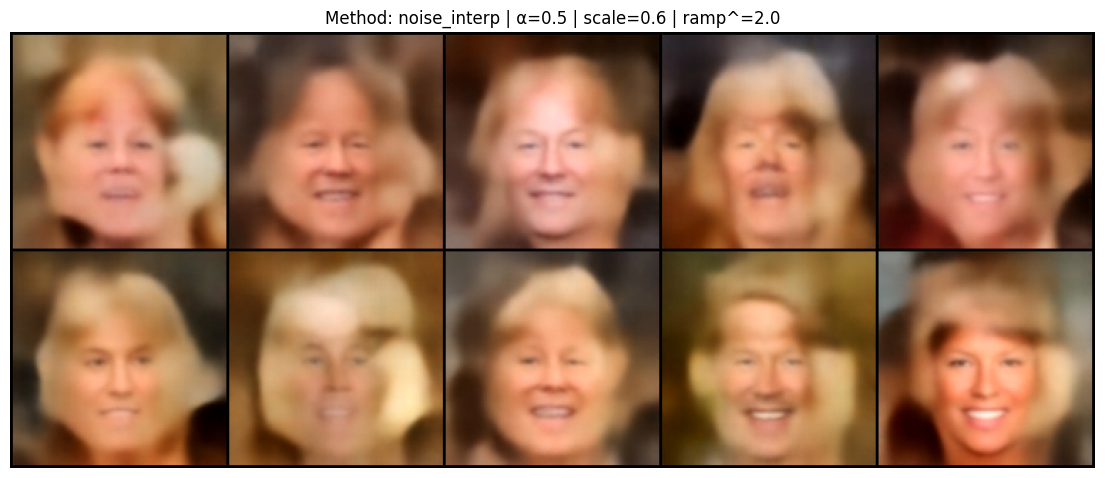

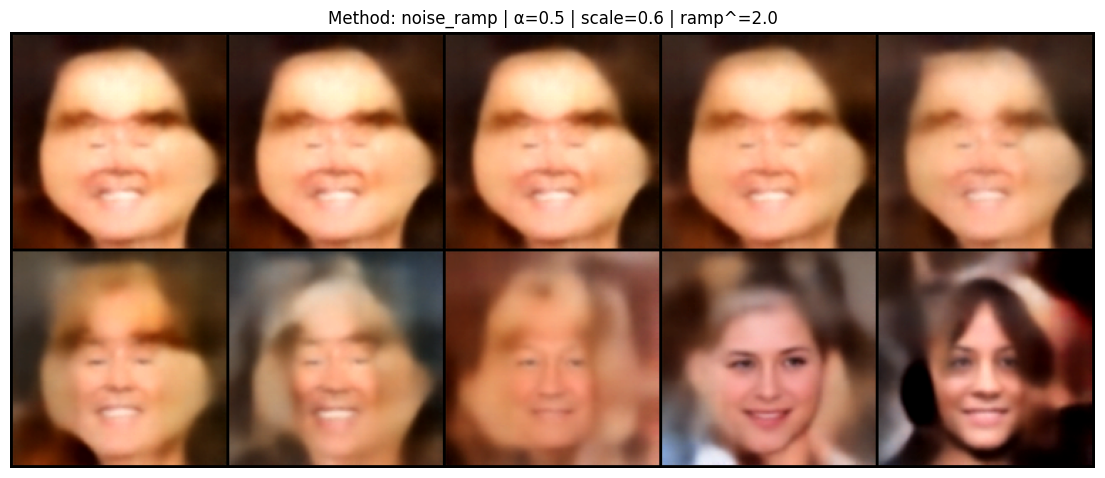

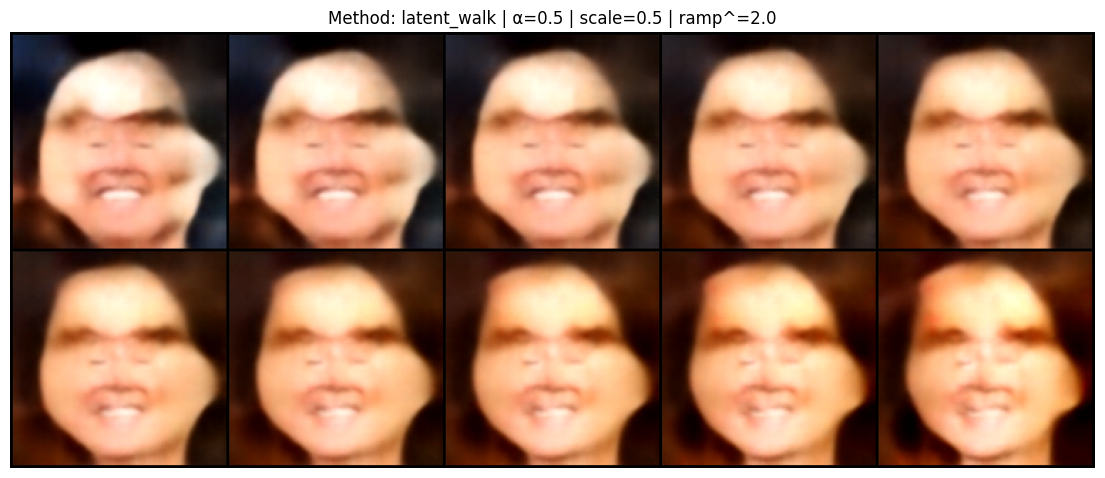

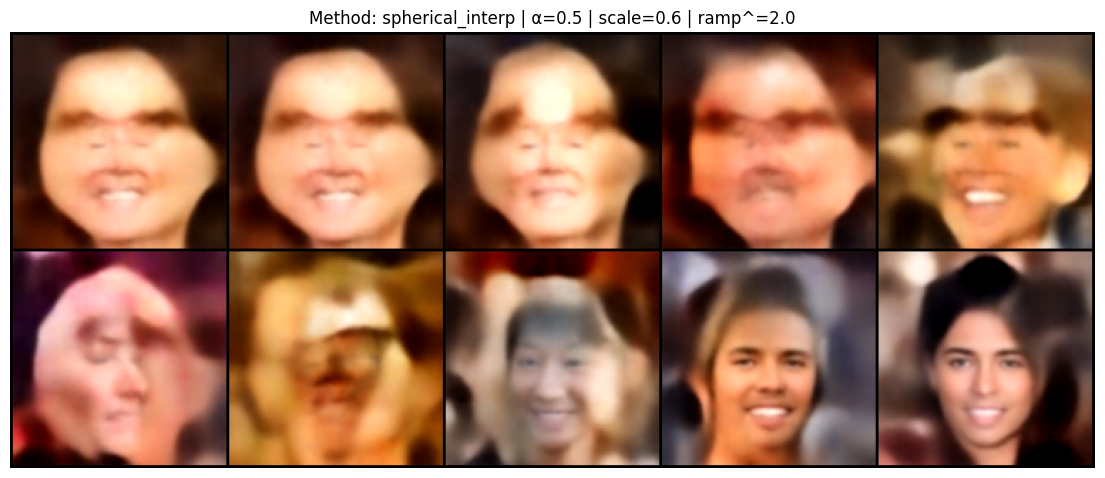

In [ ]:
show_variations(model, "example3.png", method='noise_interp', alpha=0.5)
show_variations(model, "example3.png", method='noise_ramp', ramp_power=2.0)
show_variations(model, "example3.png", method='latent_walk', walk_scale= 0.5)

## among the three variations Linear Noise Interpolation gives best results at alpha 0.5 which mixes the input and random noise equally and gives the desired output